In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models # add models to the list
from torchvision.utils import make_grid
from torch.utils.data.sampler import SubsetRandomSampler
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

### Defining Transforms

In [2]:
train_transform = transforms.Compose([
        transforms.RandomRotation(10, fill=255),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        # transforms.Resize(256),
        # transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
        # transforms.Resize(256),
        # transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

In [3]:
from torch.utils.data import Dataset
from PIL import Image

class MyDataset(Dataset):
    def __init__(self, root_dir, label_file, class_names, class_to_idx, transform):
        self.root_dir = root_dir
        self.label_file = label_file
        self.class_names = class_names
        self.class_to_idx = class_to_idx
        self.transform = transform

        # Read the labels from the Excel file
        self.labels = pd.read_excel(label_file, usecols=[1], names=['eye_color'])['eye_color'].tolist()

        # Get the list of image files (without the lambda it was not in order)
        self.image_files = []
        for root, dirs, files in os.walk(root_dir): 
            self.image_files.extend([os.path.join(root, file) for file in sorted(files, key=lambda x: int(''.join(filter(str.isdigit, x))))])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load the image and apply the transformation
        image = Image.open(self.image_files[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)

        # Convert the label to a tensor
        label = torch.tensor(self.labels[idx])
        
        return image, label

# Define the root directory of the dataset and the label file
root_dir = r'C:\Users\salda\Documents\Tanulas\4th_year\ELEC0134_AMLS1\dataset_AMLS_22-23\cartoon_set\img'
label_file = r'C:\Users\salda\Documents\Tanulas\4th_year\ELEC0134_AMLS1\dataset_AMLS_22-23\cartoon_set\labels.xlsx'
root_dir_test = r'C:\Users\salda\Documents\Tanulas\4th_year\ELEC0134_AMLS1\dataset_AMLS_22-23_test\cartoon_set_test\img'
label_file_test = r'C:\Users\salda\Documents\Tanulas\4th_year\ELEC0134_AMLS1\dataset_AMLS_22-23_test\cartoon_set_test\labels.xlsx'

# Define the class names and their corresponding indexes
class_names = ['brown', 'blue', 'green', 'grey', 'black']
class_to_idx = {'brown': 0, 'blue': 1, 'green': 2, 'grey': 3, 'black': 4}

train_data = MyDataset(root_dir, label_file, class_names, class_to_idx, transform=train_transform)
test_data = MyDataset(root_dir_test, label_file_test, class_names, class_to_idx, transform=test_transform)

torch.manual_seed(42)

val_ratio = 0.2 # ratio of the validation set (e.g., 0.2 for 20% of the data)
indices = torch.randperm(len(train_data)).tolist() # Get the indices of the data points in the training set
val_size = int(val_ratio * len(train_data)) # number of data points in the validation set

# Split the indices into training and validation sets
val_indices = indices[:val_size]
train_indices = indices[val_size:]

# Create the samplers for the training and validation sets
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

# Create the DataLoader objects for the training and validation sets
train_loader = DataLoader(train_data, batch_size=125, sampler=train_sampler)
val_loader = DataLoader(train_data, batch_size=125, sampler=val_sampler)
test_loader = DataLoader(test_data, batch_size=125, shuffle=True)

print(class_names)
print(f'Training images available: {len(train_data)}')
print(f'Testing images available:  {len(test_data)}')



['brown', 'blue', 'green', 'grey', 'black']
Training images available: 10000
Testing images available:  2500


Displaying a batch of images

Label: [4 2 1 1 3 4 1 2 4 0]
Class: black green blue blue grey black blue green black brown


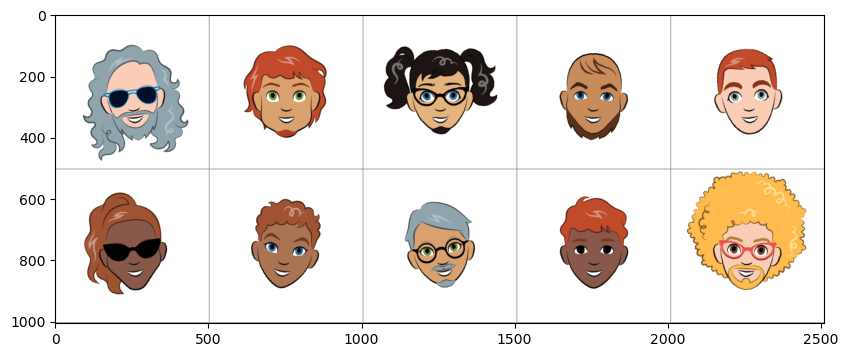

In [4]:
# Grab the first batch of images
for images,labels in train_loader: 
    break

# Print the first 10 labels
print('Label:', labels[:10].numpy())
print('Class:', *np.array([class_names[x] for x in labels[:10].numpy()]))

im = make_grid(images[:10], nrow=5) 

# Inverse normalize the images
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

# Print the images
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));


# Using pre trained model

In [5]:
RegnetY16GF = models.regnet_y_16gf(weights=models.RegNet_Y_16GF_Weights.IMAGENET1K_SWAG_E2E_V1)
RegnetY16GF

RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): Conv2dNormActivation(
          (0): Conv2d(32, 224, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): Conv2dNormActivation(
            (0): Conv2d(32, 224, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): Conv2dNormActivation(
            (0): Conv2d(224, 224, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=2, bias=False)
      

In [6]:
# Freezing parameters
for param in RegnetY16GF.parameters():
    param.requires_grad = False
  
# modifying classifier
torch.manual_seed(42)

RegnetY16GF.fc = nn.Sequential(nn.Linear(3024,1000),nn.Linear(1000,5),nn.LogSoftmax(dim=1))

# Defining loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(RegnetY16GF.fc.parameters(), lr=0.001)

for param in RegnetY16GF.fc.parameters():
    param.requires_grad = True


In [7]:
import time
start_time = time.time()

epochs = 10

# Limit nr of batches for testing
#max_trn_batch = 10
#max_val_batch = 2

train_losses = []
val_losses = []
train_correct = []
val_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1 # For the calculations later

        # Limit the number of batches for testing
        #if b == max_trn_batch:
        #    break

        # Apply the model
        y_pred = RegnetY16GF(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%(32) == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{125*b:4}/8000]  loss: {loss.item():10.8f}  |  accuracy: {trn_corr.item()*100/(125*b):7.2f}%   |   Duration: {time.time() - start_time:.0f} seconds')

    train_losses.append(loss.item())
    train_correct.append(trn_corr.item())

    # Run the testing batches
    with torch.no_grad():
        for b, (X_val, y_val) in enumerate(val_loader):
            # Limit the number of batches for test
            #if b == max_val_batch:
            #    break

            # Apply the model
            y_val_pred = RegnetY16GF(X_val)
            loss = criterion(y_val_pred, y_val)

            # Tally the number of correct predictions
            predicted = torch.max(y_val_pred.data, 1)[1] 
            tst_corr += (predicted == y_val).sum()

    val_losses.append(loss.item())
    val_correct.append(tst_corr.item())

epoch:  0  batch:   32 [4000/8000]  loss: 1.01475990  |  accuracy:   35.38%   |   Duration: 18437 seconds
epoch:  0  batch:   64 [8000/8000]  loss: 0.81693304  |  accuracy:   49.74%   |   Duration: 37102 seconds
epoch:  1  batch:   32 [4000/8000]  loss: 0.90912640  |  accuracy:   68.47%   |   Duration: 109152 seconds
epoch:  1  batch:   64 [8000/8000]  loss: 0.64781338  |  accuracy:   71.03%   |   Duration: 128597 seconds


KeyboardInterrupt: 

[1.0228101015090942, 0.812820553779602, 0.6375996470451355, 0.5970832705497742, 0.6328748464584351, 0.5580084323883057, 0.5539609789848328, 0.5173308253288269, 0.5073645710945129, 0.6282333731651306]
[1.051642894744873, 0.7393776774406433, 0.737442672252655, 0.6838027834892273, 0.5905710458755493, 0.5969964265823364, 0.7329895496368408, 0.6022558808326721, 0.7337824702262878, 0.49000978469848633]


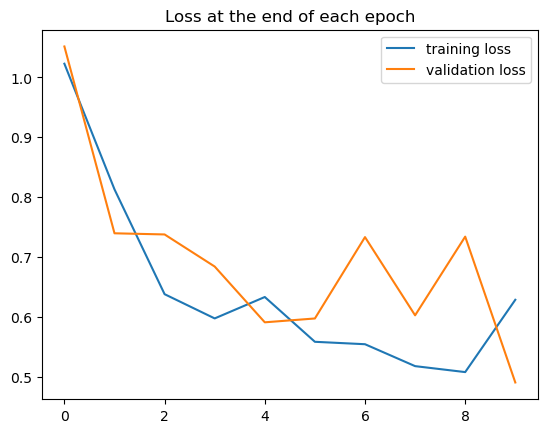

In [ ]:
print(train_losses)
print(val_losses)
plt.plot(train_losses, label='training loss')
plt.plot(val_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend()

[1226, 1376, 1406, 1449, 1432, 1497, 1435, 1464, 1469, 1518]
Test accuracy: 75.900%


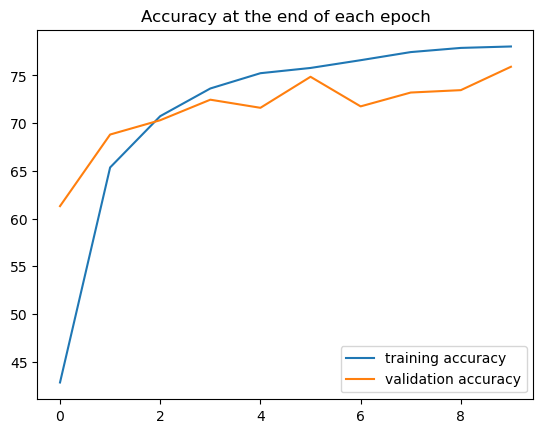

In [ ]:
print(val_correct)
print(f'Test accuracy: {val_correct[-1]*100/2000:.3f}%')
plt.plot([t/80 for t in train_correct], label='training accuracy')
plt.plot([t/20 for t in val_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [ ]:
torch.save(RegnetY16GF.state_dict(), 'B1RegnetModel.pt')